In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.style as mplstyle
%matplotlib inline
mplstyle.use('ggplot')

# Titanic Competition

The Kaggle competiton is here: [Titanic](https://www.kaggle.com/c/titanic)

## Read in the data

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Distribution of fares

The histogram below shows us that the bulk of passengers paid less than \$100 to board the Titanic. Even then the bulk paid less than $30.

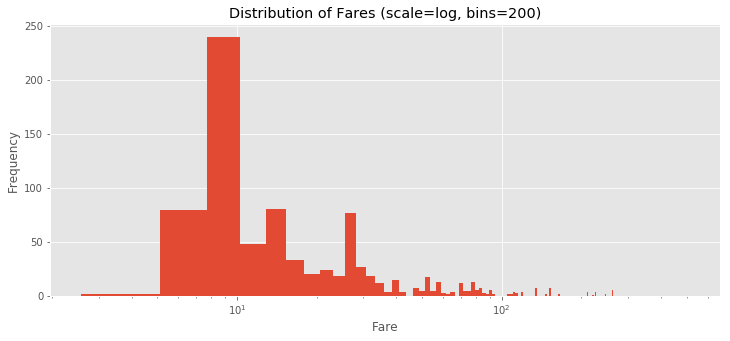

In [19]:
b = 200  # bins

fig, ax = plt.subplots(figsize=(12,5))
df['Fare'].hist(bins=b, ax=ax)
ax.set_title(f'Distribution of Fares (scale=log, bins={b})')
ax.set_xlabel('Fare')
ax.set_ylabel('Frequency')
ax.set_xscale('log')

### Suvival by fare

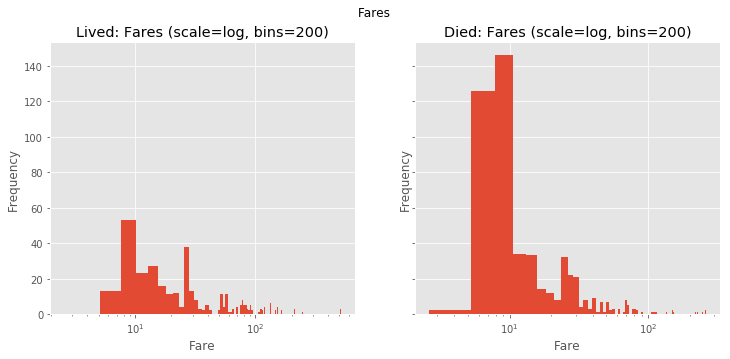

In [22]:
lived = df[df['Survived'] == 1].copy()
died = df[df['Survived'] == 0].copy()
    
b = 200  # bins

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.suptitle('Fares')
lived['Fare'].hist(bins=b, ax=ax1)
ax1.set_title(f'Lived: Fares (scale=log, bins={b})')
died['Fare'].hist(bins=100, ax=ax2)
ax2.set_title(f'Died: Fares (scale=log, bins={b})')

for i in (ax1, ax2):
    i.set_ylabel('Frequency')
    i.set_xlabel('Fare')
    i.set_xscale('log')

In [5]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

## Distribution of ages

Text(0,0.5,'Frequency')

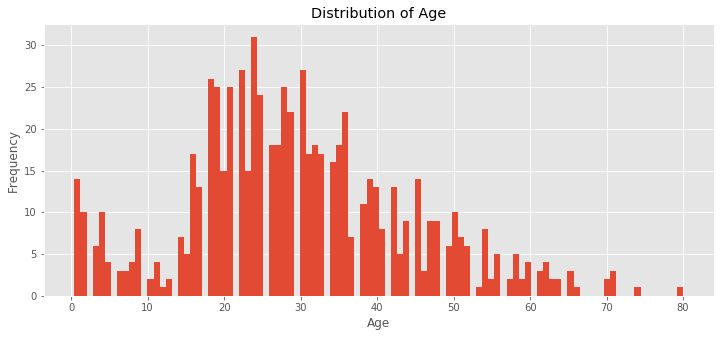

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
df['Age'].hist(bins=100, ax=ax)
ax.set_title('Distribution of Age')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')

In [8]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

### Survival by age

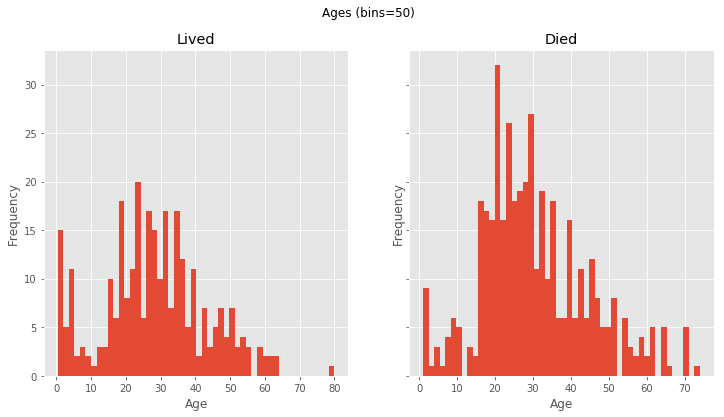

In [23]:
b = 50  # bins

lived = df[df['Survived'] == 1].copy()
died = df[df['Survived'] == 0].copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True)
fig.suptitle(f'Ages (bins={b})')
lived['Age'].hist(bins=b, ax=ax1)
ax1.set_title('Lived')
died['Age'].hist(bins=b, ax=ax2)
ax2.set_title('Died')
for i in (ax1, ax2):
    i.set_xlabel('Age')
    i.set_ylabel('Frequency')

## Survival by sex

In [6]:
g = df.groupby(['Sex', 'Survived'])
g.size().unstack()

Survived,0,1
Sex,,
female,81,233
male,468,109


## Exploration

In [32]:
g = lived.groupby(['Sex'])
g.size()

Sex
female    233
male      109
dtype: int64

In [33]:
h = died.groupby(['Sex'])
h.size()

Sex
female     81
male      468
dtype: int64

In [25]:
died.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S


# Appendix A: Columns

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
